In [ ]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm, tqdm_notebook
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.applications import VGG16
from keras.optimizers import Adam
import pickle
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the DataFrame which includes the path and label
df_data = pd.read_csv('/content/drive/MyDrive/AML/Challenge1/dataset/train.csv')  # Adjust path as needed
data_dir = '/content/drive/MyDrive/AML/Challenge1/dataset/train/train/'



df_data.shape

(17500, 2)

In [ ]:
import numpy as np
import tensorflow as tf
import random
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)


In [ ]:
import pickle
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split


# Load the images and labels
with open('/content/drive/MyDrive/AML/Challenge1/images.pickle', 'rb') as f:
    images = pickle.load(f)

with open('/content/drive/MyDrive/AML/Challenge1/labels.pickle', 'rb') as f:
    labels = pickle.load(f)

# Assume labels is a list that has been previously loaded or defined
# labels = [...]

# Create stratified training and temporary sets (validation + test)
train_indices, temp_indices, _, _ = train_test_split(
    np.arange(len(images)),  # indices of the images
    labels,                  # corresponding labels
    test_size=0.3,           # 30% for validation + test
    random_state=42,         # for reproducibility
    stratify=labels          # stratify by labels
)

# Split the temporary set into validation and test sets
val_indices, test_indices, _, _ = train_test_split(
    temp_indices,
    [labels[i] for i in temp_indices],  # extract labels for stratification
    test_size=0.5,                      # split the 30% into 15% validation and 15% test
    random_state=42,                    # for reproducibility
    stratify=[labels[i] for i in temp_indices]  # stratify by labels
)

# Use indices to select images for each dataset
train_images = [images[i] for i in train_indices]
val_images = [images[i] for i in val_indices]
test_images = [images[i] for i in test_indices]


#preprocessing
def preprocessing_images(X_tr):
    X_tr = np.asarray(X_tr)
    X_tr = X_tr.astype('float32')
    X_tr /= 255
    return X_tr

train_images = preprocessing_images(train_images)
val_images = preprocessing_images(val_images)
test_images = preprocessing_images(test_images)



# Use indices to select images for each dataset
train_labels = [labels[i] for i in train_indices]
val_labels = [labels[i] for i in val_indices]
test_labels = [labels[i] for i in test_indices]


def preprocessing_labels(labels):
  labels = np.asarray(labels)
  return labels

train_labels = preprocessing_labels(train_labels)
val_labels = preprocessing_labels(val_labels)
test_labels = preprocessing_labels(test_labels)

# Y_tr = np.asarray(Y_tr)
batch_size = 64

# Convert your training and validation data into TensorFlow datasets if not already
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)

In [ ]:
# # HP

# learning rate  = 1e-5
# batch_size = 32
# nb_epochs = 1

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import pandas as pd
from sklearn.metrics import classification_report

def train_and_evaluate(learning_rate, batch_size, nb_epochs):
    # Define the model architecture with the base model frozen
    vgg16_net = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    vgg16_net.trainable = False  # Freeze the VGG16 model

    model = Sequential()
    model.add(vgg16_net)
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # Ensure this matches your classification needs

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=learning_rate), metrics=['accuracy'])

    # Train the model
    model.fit(train_images, train_labels, batch_size=batch_size, epochs=nb_epochs,
              validation_data=(val_images, val_labels), shuffle=True, verbose=2)

    # Predict on the validation set
    val_predictions = (model.predict(val_images).flatten() > 0.5).astype(int)
    test_predictions = (model.predict(test_images).flatten() > 0.5).astype(int)

    # Generate classification reports for validation and test sets
    val_report = classification_report(val_labels, val_predictions, output_dict=True)
    test_report = classification_report(test_labels, test_predictions, output_dict=True)

    # Extract recall and F1-score for each class and averages
    results = {
        'val_recall_class_0': val_report['0']['recall'],
        'val_f1_class_0': val_report['0']['f1-score'],
        'val_recall_class_1': val_report['1']['recall'],
        'val_f1_class_1': val_report['1']['f1-score'],
        'val_recall_avg': val_report['macro avg']['recall'],
        'val_f1_avg': val_report['macro avg']['f1-score'],
        'test_recall_class_0': test_report['0']['recall'],
        'test_f1_class_0': test_report['0']['f1-score'],
        'test_recall_class_1': test_report['1']['recall'],
        'test_f1_class_1': test_report['1']['f1-score'],
        'test_recall_avg': test_report['macro avg']['recall'],
        'test_f1_avg': test_report['macro avg']['f1-score']
    }

    return results

# Define hyperparameters combinations
learning_rates = [1e-06, 1e-05]
batch_sizes = [32, 64]
epochs = [1, 2, 3]

# Loop over all combinations
all_results = []
for lr in learning_rates:
    for batch in batch_sizes:
        for epoch in epochs:
            metrics = train_and_evaluate(lr, batch, epoch)
            all_results.append((epoch, lr, batch) + tuple(metrics.values()))
            print(f"Epochs: {epoch}, Learning Rate: {lr}, Batch Size: {batch}, Metrics: {metrics}")

# Creating DataFrame
df_columns = ['Epochs', 'Learning Rate', 'Batch Size', 'Val Recall Class 0', 'Val F1 Class 0', 'Val Recall Class 1', 'Val F1 Class 1', 'Val Recall Avg', 'Val F1 Avg', 'Test Recall Class 0', 'Test F1 Class 0', 'Test Recall Class 1', 'Test F1 Class 1', 'Test Recall Avg', 'Test F1 Avg']
df_results = pd.DataFrame(all_results, columns=df_columns)
print(df_results)


58889256/58889256 [==============================] - 0s 0us/step


383/383 - 10s - loss: 0.1958 - accuracy: 0.9230 - val_loss: 0.1224 - val_accuracy: 0.9528 - 10s/epoch - 27ms/step
83/83 [==============================] - 1s 7ms/step
Epochs: 1, Learning Rate: 1e-06, Batch Size: 32, Metrics: {'val_recall_class_0': 0.8990825688073395, 'val_f1_class_0': 0.9046153846153846, 'val_recall_class_1': 0.9705733130390665, 'val_f1_class_1': 0.9686075949367089, 'val_recall_avg': 0.934827940923203, 'val_f1_avg': 0.9366114897760467, 'test_recall_class_0': 0.9251908396946565, 'test_f1_class_0': 0.9273144605967867, 'test_recall_class_1': 0.9766497461928934, 'test_f1_class_1': 0.9759066700481867, 'test_recall_avg': 0.950920292943775, 'test_f1_avg': 0.9516105653224867}


Epoch 1/2
383/383 - 5s - loss: 0.1824 - accuracy: 0.9298 - val_loss: 0.1197 - val_accuracy: 0.9554 - 5s/epoch - 13ms/step
Epoch 2/2
383/383 - 3s - loss: 0.1156 - accuracy: 0.9547 - val_loss: 0.1064 - val_accuracy: 0.9573 - 3s/epoch - 9ms/step
83/83 [==============================] - 1s 7ms/step
Epochs: 2, Learning Rate: 1e-06, Batch Size: 32, Metrics: {'val_recall_class_0': 0.9541284403669725, 'val_f1_class_0': 0.9176470588235294, 'val_recall_class_1': 0.9583967529173009, 'val_f1_class_1': 0.9712082262210797, 'val_recall_avg': 0.9562625966421368, 'val_f1_avg': 0.9444276425223046, 'test_recall_class_0': 0.9709923664122138, 'test_f1_class_0': 0.9318681318681318, 'test_recall_class_1': 0.9624365482233502, 'test_f1_class_1': 0.976061776061776, 'test_recall_avg': 0.9667144573177819, 'test_f1_avg': 0.953964953964954}


Epoch 1/3
383/383 - 5s - loss: 0.1782 - accuracy: 0.9304 - val_loss: 0.1197 - val_accuracy: 0.9539 - 5s/epoch - 13ms/step
Epoch 2/3
383/383 - 3s - loss: 0.1172 - accuracy: 0.9561 - val_loss: 0.1041 - val_accuracy: 0.9608 - 3s/epoch - 9ms/step
Epoch 3/3
383/383 - 4s - loss: 0.1044 - accuracy: 0.9599 - val_loss: 0.0935 - val_accuracy: 0.9638 - 4s/epoch - 10ms/step
83/83 [==============================] - 1s 13ms/step
Epochs: 3, Learning Rate: 1e-06, Batch Size: 32, Metrics: {'val_recall_class_0': 0.926605504587156, 'val_f1_class_0': 0.9273144605967865, 'val_recall_class_1': 0.976154236428209, 'val_f1_class_1': 0.9759066700481867, 'val_recall_avg': 0.9513798705076825, 'val_f1_avg': 0.9516105653224866, 'test_recall_class_0': 0.934351145038168, 'test_f1_class_0': 0.9350649350649352, 'test_recall_class_1': 0.9786802030456853, 'test_f1_class_1': 0.978431870083735, 'test_recall_avg': 0.9565156740419266, 'test_f1_avg': 0.9567484025743351}


192/192 - 5s - loss: 0.2066 - accuracy: 0.9189 - val_loss: 0.1264 - val_accuracy: 0.9505 - 5s/epoch - 27ms/step
83/83 [==============================] - 1s 8ms/step
Epochs: 1, Learning Rate: 1e-06, Batch Size: 64, Metrics: {'val_recall_class_0': 0.9113149847094801, 'val_f1_class_0': 0.9016641452344932, 'val_recall_class_1': 0.9634703196347032, 'val_f1_class_1': 0.9669042769857433, 'val_recall_avg': 0.9373926521720917, 'val_f1_avg': 0.9342842111101183, 'test_recall_class_0': 0.9374045801526718, 'test_f1_class_0': 0.9253956292388849, 'test_recall_class_1': 0.9705583756345177, 'test_f1_class_1': 0.974764211062962, 'test_recall_avg': 0.9539814778935948, 'test_f1_avg': 0.9500799201509234}


Epoch 1/2
192/192 - 4s - loss: 0.1960 - accuracy: 0.9236 - val_loss: 0.1245 - val_accuracy: 0.9493 - 4s/epoch - 21ms/step
Epoch 2/2
192/192 - 2s - loss: 0.1198 - accuracy: 0.9561 - val_loss: 0.1073 - val_accuracy: 0.9581 - 2s/epoch - 12ms/step
83/83 [==============================] - 1s 7ms/step
Epochs: 2, Learning Rate: 1e-06, Batch Size: 64, Metrics: {'val_recall_class_0': 0.9464831804281345, 'val_f1_class_0': 0.9183976261127595, 'val_recall_class_1': 0.9619482496194824, 'val_f1_class_1': 0.9718093285494619, 'val_recall_avg': 0.9542157150238084, 'val_f1_avg': 0.9451034773311107, 'test_recall_class_0': 0.9541984732824428, 'test_f1_class_0': 0.9266123054114159, 'test_recall_class_1': 0.9649746192893401, 'test_f1_class_1': 0.9746218918226097, 'test_recall_avg': 0.9595865462858915, 'test_f1_avg': 0.9506170986170128}


Epoch 1/3
192/192 - 4s - loss: 0.2231 - accuracy: 0.9092 - val_loss: 0.1292 - val_accuracy: 0.9493 - 4s/epoch - 21ms/step
Epoch 2/3
192/192 - 3s - loss: 0.1249 - accuracy: 0.9547 - val_loss: 0.1108 - val_accuracy: 0.9554 - 3s/epoch - 13ms/step
Epoch 3/3
192/192 - 3s - loss: 0.1088 - accuracy: 0.9597 - val_loss: 0.1023 - val_accuracy: 0.9615 - 3s/epoch - 13ms/step
83/83 [==============================] - 1s 7ms/step
Epochs: 3, Learning Rate: 1e-06, Batch Size: 64, Metrics: {'val_recall_class_0': 0.944954128440367, 'val_f1_class_0': 0.9244577412116678, 'val_recall_class_1': 0.9670218163368848, 'val_f1_class_1': 0.9741886020955789, 'val_recall_avg': 0.9559879723886259, 'val_f1_avg': 0.9493231716536233, 'test_recall_class_0': 0.9587786259541985, 'test_f1_class_0': 0.9338289962825278, 'test_recall_class_1': 0.9685279187817258, 'test_f1_class_1': 0.9772087067861716, 'test_recall_avg': 0.9636532723679622, 'test_f1_avg': 0.9555188515343497}


383/383 - 7s - loss: 0.1809 - accuracy: 0.9274 - val_loss: 0.1178 - val_accuracy: 0.9535 - 7s/epoch - 19ms/step
83/83 [==============================] - 1s 9ms/step
Epochs: 1, Learning Rate: 1e-05, Batch Size: 32, Metrics: {'val_recall_class_0': 0.9143730886850153, 'val_f1_class_0': 0.9074355083459787, 'val_recall_class_1': 0.9665144596651446, 'val_f1_class_1': 0.968972533062055, 'val_recall_avg': 0.94044377417508, 'val_f1_avg': 0.9382040207040169, 'test_recall_class_0': 0.932824427480916, 'test_f1_class_0': 0.9271623672230652, 'test_recall_class_1': 0.9736040609137055, 'test_f1_class_1': 0.9755849440488301, 'test_recall_avg': 0.9532142441973108, 'test_f1_avg': 0.9513736556359477}


Epoch 1/2
383/383 - 6s - loss: 0.1832 - accuracy: 0.9269 - val_loss: 0.1190 - val_accuracy: 0.9550 - 6s/epoch - 15ms/step
Epoch 2/2
383/383 - 4s - loss: 0.1157 - accuracy: 0.9566 - val_loss: 0.1034 - val_accuracy: 0.9615 - 4s/epoch - 10ms/step
83/83 [==============================] - 1s 7ms/step
Epochs: 2, Learning Rate: 1e-05, Batch Size: 32, Metrics: {'val_recall_class_0': 0.9556574923547401, 'val_f1_class_0': 0.9252405625462621, 'val_recall_class_1': 0.9634703196347032, 'val_f1_class_1': 0.97409592203129, 'val_recall_avg': 0.9595639059947216, 'val_f1_avg': 0.9496682422887761, 'test_recall_class_0': 0.9648854961832061, 'test_f1_class_0': 0.9321533923303834, 'test_recall_class_1': 0.9649746192893401, 'test_f1_class_1': 0.9763739085772984, 'test_recall_avg': 0.9649300577362732, 'test_f1_avg': 0.9542636504538409}


Epoch 1/3
383/383 - 6s - loss: 0.1856 - accuracy: 0.9260 - val_loss: 0.1207 - val_accuracy: 0.9524 - 6s/epoch - 15ms/step
Epoch 2/3
383/383 - 4s - loss: 0.1137 - accuracy: 0.9580 - val_loss: 0.1057 - val_accuracy: 0.9585 - 4s/epoch - 10ms/step
Epoch 3/3
383/383 - 4s - loss: 0.1048 - accuracy: 0.9591 - val_loss: 0.0936 - val_accuracy: 0.9642 - 4s/epoch - 10ms/step
83/83 [==============================] - 1s 7ms/step
Epochs: 3, Learning Rate: 1e-05, Batch Size: 32, Metrics: {'val_recall_class_0': 0.9342507645259939, 'val_f1_class_0': 0.9285714285714286, 'val_recall_class_1': 0.974124809741248, 'val_f1_class_1': 0.9761057447890187, 'val_recall_avg': 0.954187787133621, 'val_f1_avg': 0.9523385866802236, 'test_recall_class_0': 0.9465648854961832, 'test_f1_class_0': 0.9401061410159212, 'test_recall_class_1': 0.9776649746192894, 'test_f1_class_1': 0.9799033324853726, 'test_recall_avg': 0.9621149300577363, 'test_f1_avg': 0.9600047367506469}


192/192 - 4s - loss: 0.2276 - accuracy: 0.9066 - val_loss: 0.1313 - val_accuracy: 0.9493 - 4s/epoch - 20ms/step
83/83 [==============================] - 1s 7ms/step
Epochs: 1, Learning Rate: 1e-05, Batch Size: 64, Metrics: {'val_recall_class_0': 0.8929663608562691, 'val_f1_class_0': 0.8977709454265949, 'val_recall_class_1': 0.9680365296803652, 'val_f1_class_1': 0.9663205874905039, 'val_recall_avg': 0.9305014452683171, 'val_f1_avg': 0.9320457664585493, 'test_recall_class_0': 0.9251908396946565, 'test_f1_class_0': 0.9216730038022815, 'test_recall_class_1': 0.9725888324873097, 'test_f1_class_1': 0.9738246505717917, 'test_recall_avg': 0.9488898360909831, 'test_f1_avg': 0.9477488271870366}


Epoch 1/2
192/192 - 4s - loss: 0.2194 - accuracy: 0.9118 - val_loss: 0.1289 - val_accuracy: 0.9478 - 4s/epoch - 18ms/step
Epoch 2/2
192/192 - 2s - loss: 0.1220 - accuracy: 0.9540 - val_loss: 0.1085 - val_accuracy: 0.9570 - 2s/epoch - 12ms/step
83/83 [==============================] - 1s 7ms/step
Epochs: 2, Learning Rate: 1e-05, Batch Size: 64, Metrics: {'val_recall_class_0': 0.9327217125382263, 'val_f1_class_0': 0.9152288072018003, 'val_recall_class_1': 0.9649923896499238, 'val_f1_class_1': 0.9711513913709471, 'val_recall_avg': 0.948857051094075, 'val_f1_avg': 0.9431900992863738, 'test_recall_class_0': 0.9511450381679389, 'test_f1_class_0': 0.9333333333333333, 'test_recall_class_1': 0.9710659898477157, 'test_f1_class_1': 0.9772669220945084, 'test_recall_avg': 0.9611055140078273, 'test_f1_avg': 0.9553001277139208}


Epoch 1/3
192/192 - 4s - loss: 0.1992 - accuracy: 0.9229 - val_loss: 0.1260 - val_accuracy: 0.9509 - 4s/epoch - 21ms/step
Epoch 2/3
192/192 - 3s - loss: 0.1219 - accuracy: 0.9544 - val_loss: 0.1067 - val_accuracy: 0.9585 - 3s/epoch - 13ms/step
Epoch 3/3
192/192 - 2s - loss: 0.1069 - accuracy: 0.9596 - val_loss: 0.1045 - val_accuracy: 0.9615 - 2s/epoch - 12ms/step
83/83 [==============================] - 1s 7ms/step
Epochs: 3, Learning Rate: 1e-05, Batch Size: 64, Metrics: {'val_recall_class_0': 0.9617737003058104, 'val_f1_class_0': 0.9256806475349522, 'val_recall_class_1': 0.9614408929477423, 'val_f1_class_1': 0.9740426625546131, 'val_recall_avg': 0.9616072966267764, 'val_f1_avg': 0.9498616550447827, 'test_recall_class_0': 0.9740458015267176, 'test_f1_class_0': 0.935483870967742, 'test_recall_class_1': 0.9639593908629441, 'test_f1_class_1': 0.97735460627895, 'test_recall_avg': 0.9690025961948309, 'test_f1_avg': 0.956419238623346}
    Epochs  Learning Rate  Batch Size  Val Recall Class 

In [ ]:
import pandas as pd

# Assuming 'df_results' is the DataFrame from your code output
# Select only columns related to the test set
columns_of_interest = ['Epochs', 'Learning Rate', 'Batch Size', 'Test Recall Class 0', 'Test F1 Class 0', 'Test Recall Class 1', 'Test F1 Class 1', 'Test Recall Avg', 'Test F1 Avg']
df_test_results = df_results[columns_of_interest]

# Print the formatted DataFrame
print(df_test_results)


    Epochs  Learning Rate  Batch Size  Test Recall Class 0  Test F1 Class 0  \
0        1       0.000001          32             0.925191         0.927314   
1        2       0.000001          32             0.970992         0.931868   
2        3       0.000001          32             0.934351         0.935065   
3        1       0.000001          64             0.937405         0.925396   
4        2       0.000001          64             0.954198         0.926612   
5        3       0.000001          64             0.958779         0.933829   
6        1       0.000010          32             0.932824         0.927162   
7        2       0.000010          32             0.964885         0.932153   
8        3       0.000010          32             0.946565         0.940106   
9        1       0.000010          64             0.925191         0.921673   
10       2       0.000010          64             0.951145         0.933333   
11       3       0.000010          64             0.

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
import pandas as pd
from sklearn.metrics import classification_report

def train_and_evaluate(learning_rate, batch_size, nb_epochs):
    # Define the model architecture
    vgg16_net = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    vgg16_net.trainable = True

    model = Sequential()
    model.add(vgg16_net)
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # Ensure this matches your classification needs

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=learning_rate), metrics=['accuracy'])

    # Train the model
    model.fit(train_images, train_labels, batch_size=batch_size, epochs=nb_epochs,
              validation_data=(val_images, val_labels), shuffle=True, verbose=2)

    # Predict on the validation set
    val_predictions = (model.predict(val_images).flatten() > 0.5).astype(int)

    # Predict on the test set
    test_predictions = (model.predict(test_images).flatten() > 0.5).astype(int)

    # Generate classification reports for validation and test sets
    val_report = classification_report(val_labels, val_predictions, output_dict=True)
    test_report = classification_report(test_labels, test_predictions, output_dict=True)

    # Extract recall and F1-score for each class and averages
    results = {
        'val_recall_class_0': val_report['0']['recall'],
        'val_f1_class_0': val_report['0']['f1-score'],
        'val_recall_class_1': val_report['1']['recall'],
        'val_f1_class_1': val_report['1']['f1-score'],
        'val_recall_avg': val_report['macro avg']['recall'],
        'val_f1_avg': val_report['macro avg']['f1-score'],
        'test_recall_class_0': test_report['0']['recall'],
        'test_f1_class_0': test_report['0']['f1-score'],
        'test_recall_class_1': test_report['1']['recall'],
        'test_f1_class_1': test_report['1']['f1-score'],
        'test_recall_avg': test_report['macro avg']['recall'],
        'test_f1_avg': test_report['macro avg']['f1-score']
    }

    return results

# Define hyperparameters combinations
learning_rates = [1e-06, 1e-05]
batch_sizes = [32, 64]
epochs = [1, 2, 3]

# Loop over all combinations
all_results = []
for lr in learning_rates:
    for batch in batch_sizes:
        for epoch in epochs:
            metrics = train_and_evaluate(lr, batch, epoch)
            all_results.append((epoch, lr, batch) + tuple(metrics.values()))
            print(f"Epochs: {epoch}, Learning Rate: {lr}, Batch Size: {batch}, Metrics: {metrics}")

# Creating DataFrame
df_columns = ['Epochs', 'Learning Rate', 'Batch Size', 'Val Recall Class 0', 'Val F1 Class 0', 'Val Recall Class 1', 'Val F1 Class 1', 'Val Recall Avg', 'Val F1 Avg', 'Test Recall Class 0', 'Test F1 Class 0', 'Test Recall Class 1', 'Test F1 Class 1', 'Test Recall Avg', 'Test F1 Avg']
df_results = pd.DataFrame(all_results, columns=df_columns)
print(df_results)


58889256/58889256 [==============================] - 4s 0us/step


383/383 - 24s - loss: 0.4336 - accuracy: 0.8418 - val_loss: 0.2937 - val_accuracy: 0.8667 - 24s/epoch - 62ms/step
83/83 [==============================] - 1s 7ms/step
Epochs: 1, Learning Rate: 1e-06, Batch Size: 32, Metrics: {'val_recall_class_0': 0.5198776758409785, 'val_f1_class_0': 0.6601941747572816, 'val_recall_class_1': 0.9817351598173516, 'val_f1_class_1': 0.9170616113744076, 'val_recall_avg': 0.7508064178291651, 'val_f1_avg': 0.7886278930658446, 'test_recall_class_0': 0.5251908396946565, 'test_f1_class_0': 0.6596356663470758, 'test_recall_class_1': 0.9776649746192894, 'test_f1_class_1': 0.9156168290943666, 'test_recall_avg': 0.7514279071569729, 'test_f1_avg': 0.7876262477207212}


Epoch 1/2
383/383 - 16s - loss: 0.1962 - accuracy: 0.9233 - val_loss: 0.0789 - val_accuracy: 0.9714 - 16s/epoch - 42ms/step
Epoch 2/2
383/383 - 11s - loss: 0.2463 - accuracy: 0.9251 - val_loss: 0.5173 - val_accuracy: 0.7509 - 11s/epoch - 29ms/step
83/83 [==============================] - 1s 7ms/step
Epochs: 2, Learning Rate: 1e-06, Batch Size: 32, Metrics: {'val_recall_class_0': 0.0, 'val_f1_class_0': 0.0, 'val_recall_class_1': 1.0, 'val_f1_class_1': 0.8577023498694517, 'val_recall_avg': 0.5, 'val_f1_avg': 0.42885117493472585, 'test_recall_class_0': 0.0, 'test_f1_class_0': 0.0, 'test_recall_class_1': 1.0, 'test_f1_class_1': 0.8574537540805224, 'test_recall_avg': 0.5, 'test_f1_avg': 0.4287268770402612}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Epoch 1/3
383/383 - 15s - loss: 0.1866 - accuracy: 0.9289 - val_loss: 0.0676 - val_accuracy: 0.9768 - 15s/epoch - 40ms/step
Epoch 2/3
383/383 - 11s - loss: 0.0664 - accuracy: 0.9789 - val_loss: 0.0328 - val_accuracy: 0.9882 - 11s/epoch - 29ms/step
Epoch 3/3
383/383 - 11s - loss: 0.1002 - accuracy: 0.9705 - val_loss: 0.0361 - val_accuracy: 0.9901 - 11s/epoch - 29ms/step
83/83 [==============================] - 1s 7ms/step
Epochs: 3, Learning Rate: 1e-06, Batch Size: 32, Metrics: {'val_recall_class_0': 0.9770642201834863, 'val_f1_class_0': 0.9800613496932515, 'val_recall_class_1': 0.9944190766108574, 'val_f1_class_1': 0.99341104916371, 'val_recall_avg': 0.9857416483971718, 'val_f1_avg': 0.9867361994284808, 'test_recall_class_0': 0.966412213740458, 'test_f1_class_0': 0.9745958429561202, 'test_recall_class_1': 0.9944162436548223, 'test_f1_class_1': 0.9916476841305998, 'test_recall_avg': 0.9804142286976402, 'test_f1_avg': 0.98312176354336}


192/192 - 15s - loss: 0.3856 - accuracy: 0.8682 - val_loss: 0.0761 - val_accuracy: 0.9760 - 15s/epoch - 77ms/step
83/83 [==============================] - 1s 7ms/step
Epochs: 1, Learning Rate: 1e-06, Batch Size: 64, Metrics: {'val_recall_class_0': 0.9159021406727829, 'val_f1_class_0': 0.9500396510705789, 'val_recall_class_1': 0.9959411466260781, 'val_f1_class_1': 0.984206568062171, 'val_recall_avg': 0.9559216436494304, 'val_f1_avg': 0.9671231095663749, 'test_recall_class_0': 0.9267175572519084, 'test_f1_class_0': 0.9559055118110236, 'test_recall_class_1': 0.9959390862944163, 'test_f1_class_1': 0.9859296482412061, 'test_recall_avg': 0.9613283217731623, 'test_f1_avg': 0.9709175800261148}


Epoch 1/2
192/192 - 11s - loss: 0.3551 - accuracy: 0.8550 - val_loss: 0.0685 - val_accuracy: 0.9745 - 11s/epoch - 60ms/step
Epoch 2/2
192/192 - 7s - loss: 0.1008 - accuracy: 0.9686 - val_loss: 0.1376 - val_accuracy: 0.9573 - 7s/epoch - 37ms/step
83/83 [==============================] - 1s 7ms/step
Epochs: 2, Learning Rate: 1e-06, Batch Size: 64, Metrics: {'val_recall_class_0': 0.8348623853211009, 'val_f1_class_0': 0.9069767441860465, 'val_recall_class_1': 0.9979705733130391, 'val_f1_class_1': 0.972318339100346, 'val_recall_avg': 0.9164164793170699, 'val_f1_avg': 0.9396475416431962, 'test_recall_class_0': 0.8519083969465648, 'test_f1_class_0': 0.9185185185185185, 'test_recall_class_1': 0.9989847715736041, 'test_f1_class_1': 0.97546468401487, 'test_recall_avg': 0.9254465842600845, 'test_f1_avg': 0.9469916012666942}


Epoch 1/3
192/192 - 12s - loss: 0.3449 - accuracy: 0.8531 - val_loss: 0.1235 - val_accuracy: 0.9615 - 12s/epoch - 63ms/step
Epoch 2/3
192/192 - 7s - loss: 0.0753 - accuracy: 0.9758 - val_loss: 0.0649 - val_accuracy: 0.9771 - 7s/epoch - 39ms/step
Epoch 3/3
192/192 - 7s - loss: 0.1066 - accuracy: 0.9673 - val_loss: 0.0526 - val_accuracy: 0.9821 - 7s/epoch - 37ms/step
83/83 [==============================] - 1s 7ms/step
Epochs: 3, Learning Rate: 1e-06, Batch Size: 64, Metrics: {'val_recall_class_0': 0.9892966360856269, 'val_f1_class_0': 0.964951528709918, 'val_recall_class_1': 0.9797057331303907, 'val_f1_class_1': 0.9879764645689434, 'val_recall_avg': 0.9845011846080087, 'val_f1_avg': 0.9764639966394306, 'test_recall_class_0': 0.9923664122137404, 'test_f1_class_0': 0.9643916913946587, 'test_recall_class_1': 0.9781725888324873, 'test_f1_class_1': 0.9876986160943105, 'test_recall_avg': 0.9852695005231138, 'test_f1_avg': 0.9760451537444846}


383/383 - 15s - loss: 0.2316 - accuracy: 0.9113 - val_loss: 0.0606 - val_accuracy: 0.9794 - 15s/epoch - 40ms/step
83/83 [==============================] - 1s 9ms/step
Epochs: 1, Learning Rate: 1e-05, Batch Size: 32, Metrics: {'val_recall_class_0': 0.9724770642201835, 'val_f1_class_0': 0.9592760180995474, 'val_recall_class_1': 0.9817351598173516, 'val_f1_class_1': 0.9862385321100918, 'val_recall_avg': 0.9771061120187676, 'val_f1_avg': 0.9727572751048197, 'test_recall_class_0': 0.9755725190839695, 'test_f1_class_0': 0.969650986342944, 'test_recall_class_1': 0.9878172588832488, 'test_f1_class_1': 0.9898270600203459, 'test_recall_avg': 0.9816948889836091, 'test_f1_avg': 0.979739023181645}


Epoch 1/2
383/383 - 22s - loss: 0.2687 - accuracy: 0.9056 - val_loss: 0.1097 - val_accuracy: 0.9585 - 22s/epoch - 56ms/step
Epoch 2/2
383/383 - 11s - loss: 0.0632 - accuracy: 0.9784 - val_loss: 0.0510 - val_accuracy: 0.9897 - 11s/epoch - 30ms/step
83/83 [==============================] - 1s 7ms/step
Epochs: 2, Learning Rate: 1e-05, Batch Size: 32, Metrics: {'val_recall_class_0': 0.9709480122324159, 'val_f1_class_0': 0.9791827293754819, 'val_recall_class_1': 0.9959411466260781, 'val_f1_class_1': 0.9931697444978498, 'val_recall_avg': 0.983444579429247, 'val_f1_avg': 0.9861762369366658, 'test_recall_class_0': 0.9725190839694656, 'test_f1_class_0': 0.9777436684574061, 'test_recall_class_1': 0.9944162436548223, 'test_f1_class_1': 0.9926526475804408, 'test_recall_avg': 0.983467663812144, 'test_f1_avg': 0.9851981580189235}


Epoch 1/3
383/383 - 15s - loss: 0.2734 - accuracy: 0.8889 - val_loss: 0.0905 - val_accuracy: 0.9611 - 15s/epoch - 40ms/step
Epoch 2/3
383/383 - 11s - loss: 0.1245 - accuracy: 0.9567 - val_loss: 0.0840 - val_accuracy: 0.9695 - 11s/epoch - 30ms/step
Epoch 3/3
383/383 - 11s - loss: 0.1486 - accuracy: 0.9575 - val_loss: 0.1521 - val_accuracy: 0.9383 - 11s/epoch - 30ms/step
83/83 [==============================] - 1s 7ms/step
Epochs: 3, Learning Rate: 1e-05, Batch Size: 32, Metrics: {'val_recall_class_0': 0.7951070336391437, 'val_f1_class_0': 0.86522462562396, 'val_recall_class_1': 0.9857940131912735, 'val_f1_class_1': 0.9599802371541502, 'val_recall_avg': 0.8904505234152086, 'val_f1_avg': 0.9126024313890551, 'test_recall_class_0': 0.7786259541984732, 'test_f1_class_0': 0.8578637510513035, 'test_recall_class_1': 0.9878172588832488, 'test_f1_class_1': 0.9583846343265207, 'test_recall_avg': 0.883221606540861, 'test_f1_avg': 0.9081241926889121}


192/192 - 12s - loss: 0.2627 - accuracy: 0.8927 - val_loss: 0.0938 - val_accuracy: 0.9627 - 12s/epoch - 63ms/step
83/83 [==============================] - 1s 7ms/step
Epochs: 1, Learning Rate: 1e-05, Batch Size: 64, Metrics: {'val_recall_class_0': 0.8685015290519877, 'val_f1_class_0': 0.9205834683954619, 'val_recall_class_1': 0.9939117199391172, 'val_f1_class_1': 0.975597609561753, 'val_recall_avg': 0.9312066244955525, 'val_f1_avg': 0.9480905389786074, 'test_recall_class_0': 0.8656488549618321, 'test_f1_class_0': 0.9242053789731051, 'test_recall_class_1': 0.9974619289340102, 'test_f1_class_1': 0.976882923191648, 'test_recall_avg': 0.9315553919479211, 'test_f1_avg': 0.9505441510823766}


Epoch 1/2
192/192 - 11s - loss: 0.2780 - accuracy: 0.8962 - val_loss: 0.0846 - val_accuracy: 0.9775 - 11s/epoch - 60ms/step
Epoch 2/2
192/192 - 7s - loss: 0.0617 - accuracy: 0.9793 - val_loss: 0.0354 - val_accuracy: 0.9897 - 7s/epoch - 37ms/step
83/83 [==============================] - 1s 7ms/step
Epochs: 2, Learning Rate: 1e-05, Batch Size: 64, Metrics: {'val_recall_class_0': 0.9801223241590215, 'val_f1_class_0': 0.9793735676088617, 'val_recall_class_1': 0.9928970065956367, 'val_f1_class_1': 0.9931489469677747, 'val_recall_avg': 0.9865096653773291, 'val_f1_avg': 0.9862612572883183, 'test_recall_class_0': 0.981679389312977, 'test_f1_class_0': 0.9854406130268198, 'test_recall_class_1': 0.9964467005076142, 'test_f1_class_1': 0.9951837769328263, 'test_recall_avg': 0.9890630449102956, 'test_f1_avg': 0.990312194979823}


Epoch 1/3
192/192 - 12s - loss: 0.2816 - accuracy: 0.8897 - val_loss: 0.0591 - val_accuracy: 0.9802 - 12s/epoch - 61ms/step
Epoch 2/3
192/192 - 7s - loss: 0.0643 - accuracy: 0.9789 - val_loss: 0.0478 - val_accuracy: 0.9817 - 7s/epoch - 39ms/step
Epoch 3/3
192/192 - 7s - loss: 0.0481 - accuracy: 0.9837 - val_loss: 0.0461 - val_accuracy: 0.9848 - 7s/epoch - 39ms/step
83/83 [==============================] - 1s 7ms/step
Epochs: 3, Learning Rate: 1e-05, Batch Size: 64, Metrics: {'val_recall_class_0': 0.9480122324159022, 'val_f1_class_0': 0.96875, 'val_recall_class_1': 0.9969558599695586, 'val_f1_class_1': 0.9899244332493703, 'val_recall_avg': 0.9724840461927304, 'val_f1_avg': 0.9793372166246852, 'test_recall_class_0': 0.9419847328244275, 'test_f1_class_0': 0.966327329678935, 'test_recall_class_1': 0.9974619289340102, 'test_f1_class_1': 0.9891769443745282, 'test_recall_avg': 0.9697233308792188, 'test_f1_avg': 0.9777521370267316}
    Epochs  Learning Rate  Batch Size  Val Recall Class 0  Val

In [ ]:
import pandas as pd

# Assuming 'df_results' is the DataFrame from your code output
# Select only columns related to the test set
columns_of_interest = ['Epochs', 'Learning Rate', 'Batch Size', 'Test Recall Class 0', 'Test F1 Class 0', 'Test Recall Class 1', 'Test F1 Class 1', 'Test Recall Avg', 'Test F1 Avg']
df_test_results = df_results[columns_of_interest]

# Print the formatted DataFrame
print(df_test_results)


    Epochs  Learning Rate  Batch Size  Test Recall Class 0  Test F1 Class 0  \
0        1       0.000001          32             0.525191         0.659636   
1        2       0.000001          32             0.000000         0.000000   
2        3       0.000001          32             0.966412         0.974596   
3        1       0.000001          64             0.926718         0.955906   
4        2       0.000001          64             0.851908         0.918519   
5        3       0.000001          64             0.992366         0.964392   
6        1       0.000010          32             0.975573         0.969651   
7        2       0.000010          32             0.972519         0.977744   
8        3       0.000010          32             0.778626         0.857864   
9        1       0.000010          64             0.865649         0.924205   
10       2       0.000010          64             0.981679         0.985441   
11       3       0.000010          64             0.

In [ ]:
import pandas as pd

# Sample data creation (replace this with your actual DataFrame loading method)
data = {
    'Epochs': [1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3],
    'Learning Rate': [1e-6]*6 + [1e-5]*6,
    'Batch Size': [32]*3 + [64]*3 + [32]*3 + [64]*3,
    'Test Recall Class 0': [0.525, 0.000, 0.966, 0.927, 0.852, 0.992, 0.976, 0.973, 0.779, 0.866, 0.982, 0.942],
    'Test F1 Class 0': [0.660, 0.000, 0.975, 0.956, 0.919, 0.964, 0.970, 0.978, 0.858, 0.924, 0.985, 0.966],
    'Test Recall Class 1': [0.978, 1.000, 0.994, 0.996, 0.999, 0.978, 0.988, 0.994, 0.988, 0.997, 0.996, 0.997],
    'Test F1 Class 1': [0.916, 0.857, 0.992, 0.986, 0.975, 0.988, 0.990, 0.993, 0.958, 0.977, 0.995, 0.989],
    'Test Recall Avg': [0.751, 0.500, 0.980, 0.961, 0.925, 0.985, 0.982, 0.983, 0.883, 0.932, 0.989, 0.970],
    'Test F1 Avg': [0.788, 0.429, 0.983, 0.971, 0.947, 0.976, 0.980, 0.985, 0.908, 0.951, 0.990, 0.978]
}
df_results = pd.DataFrame(data)

# Formatting similar to classification_report
grouped_results = df_results.groupby('Epochs').agg({
    'Test Recall Class 0': 'mean',
    'Test F1 Class 0': 'mean',
    'Test Recall Class 1': 'mean',
    'Test F1 Class 1': 'mean',
    'Test Recall Avg': 'mean',
    'Test F1 Avg': 'mean'
}).reset_index()

# Custom print format
print("Classification Report:\n")
print("{:<11} {:<15} {:<15} {:<15} {:<15}".format("", "Precision", "Recall", "F1-score", "Support"))
for index, row in grouped_results.iterrows():
    print(f"Epoch {row['Epochs']}:")
    print("{:<11} {:<15} {:<15} {:<15} {:<15}".format("Class 0", round(row['Test F1 Class 0'], 2), round(row['Test Recall Class 0'], 2), round(row['Test F1 Class 0'], 2), ""))
    print("{:<11} {:<15} {:<15} {:<15} {:<15}".format("Class 1", round(row['Test F1 Class 1'], 2), round(row['Test Recall Class 1'], 2), round(row['Test F1 Class 1'], 2), ""))
    print("{:<11} {:<15} {:<15} {:<15} {:<15}".format("Avg/Total", round(row['Test F1 Avg'], 2), round(row['Test Recall Avg'], 2), round(row['Test F1 Avg'], 2), ""))
    print("\n")


Classification Report:

            Precision       Recall          F1-score        Support        
Epoch 1.0:
Class 0     0.88            0.82            0.88                           
Class 1     0.97            0.99            0.97                           
Avg/Total   0.92            0.91            0.92                           


Epoch 2.0:
Class 0     0.72            0.7             0.72                           
Class 1     0.96            1.0             0.96                           
Avg/Total   0.84            0.85            0.84                           


Epoch 3.0:
Class 0     0.94            0.92            0.94                           
Class 1     0.98            0.99            0.98                           
Avg/Total   0.96            0.95            0.96                           




In [ ]:
# from tensorflow.keras.applications import VGG16
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Flatten, Dense, Activation, Dropout
# from tensorflow.keras.optimizers import Adam
# import pandas as pd
# from sklearn.metrics import matthews_corrcoef

# def train_and_evaluate(learning_rate, batch_size, nb_epochs):
#     # Define the model architecture
#     vgg16_net = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
#     vgg16_net.trainable = True

#     model = Sequential()
#     model.add(vgg16_net)
#     model.add(Flatten())
#     model.add(Dense(256, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(1, activation='sigmoid'))

#     # Compile the model
#     model.compile(loss='binary_crossentropy', optimizer=Adam(lr=learning_rate), metrics=['accuracy'])

#     # Train the model
#     model.fit(train_images, train_labels, batch_size=batch_size, epochs=nb_epochs,
#               validation_data=(val_images, val_labels), shuffle=True, verbose=2)

#     # Predict on the validation set
#     val_predictions = model.predict(val_images).flatten()
#     val_binary_predictions = val_predictions > 0.5

#     # Predict on the test set
#     test_predictions = model.predict(test_images).flatten()
#     test_binary_predictions = test_predictions > 0.5

#     # Calculate MCC for validation and test sets
#     val_mcc = matthews_corrcoef(val_labels, val_binary_predictions)
#     test_mcc = matthews_corrcoef(test_labels, test_binary_predictions)

#     return val_mcc, test_mcc

# # Define hyperparameters combinations
# learning_rates = [1e-06, 1e-05]
# batch_sizes = [32, 64]
# epochs = [1, 2, 3]

# # Loop over all combinations
# results = []
# for lr in learning_rates:
#     for batch in batch_sizes:
#         for epoch in epochs:
#             val_mcc, test_mcc = train_and_evaluate(lr, batch, epoch)
#             results.append((epoch, lr, batch, val_mcc, test_mcc))
#             print(f"Epochs: {epoch}, Learning Rate: {lr}, Batch Size: {batch}, Validation MCC: {val_mcc}, Test MCC: {test_mcc}")
#             df_results = pd.DataFrame(results, columns=['Epochs', 'Learning Rate', 'Batch Size', 'Validation MCC', 'Test MCC'])
#             print(df_results)




766/766 - 31s - loss: 0.5807 - accuracy: 0.7463 - val_loss: 0.5736 - val_accuracy: 0.7509 - 31s/epoch - 40ms/step
83/83 [==============================] - 1s 7ms/step
Epochs: 1, Learning Rate: 1e-06, Batch Size: 16, Validation MCC: 0.0, Test MCC: 0.0
   Epochs  Learning Rate  Batch Size  Validation MCC  Test MCC
0       1       0.000001          16             0.0       0.0


Epoch 1/2
766/766 - 22s - loss: 0.2620 - accuracy: 0.8957 - val_loss: 0.0624 - val_accuracy: 0.9741 - 22s/epoch - 29ms/step
Epoch 2/2
766/766 - 18s - loss: 0.1717 - accuracy: 0.9405 - val_loss: 0.1357 - val_accuracy: 0.9573 - 18s/epoch - 24ms/step
83/83 [==============================] - 1s 7ms/step
Epochs: 2, Learning Rate: 1e-06, Batch Size: 16, Validation MCC: 0.892703378082925, Test MCC: 0.8920491510147911
   Epochs  Learning Rate  Batch Size  Validation MCC  Test MCC
0       1       0.000001          16        0.000000  0.000000
1       2       0.000001          16        0.892703  0.892049


Epoch 1/3
766/766 - 22s - loss: 0.2683 - accuracy: 0.9029 - val_loss: 0.1517 - val_accuracy: 0.9467 - 22s/epoch - 29ms/step
Epoch 2/3
766/766 - 19s - loss: 0.5317 - accuracy: 0.7944 - val_loss: 0.4979 - val_accuracy: 0.7509 - 19s/epoch - 24ms/step
Epoch 3/3
766/766 - 18s - loss: 0.2073 - accuracy: 0.9178 - val_loss: 0.1609 - val_accuracy: 0.9406 - 18s/epoch - 23ms/step
83/83 [==============================] - 1s 7ms/step
Epochs: 3, Learning Rate: 1e-06, Batch Size: 16, Validation MCC: 0.838530862262231, Test MCC: 0.8412731596929467
   Epochs  Learning Rate  Batch Size  Validation MCC  Test MCC
0       1       0.000001          16        0.000000  0.000000
1       2       0.000001          16        0.892703  0.892049
2       3       0.000001          16        0.838531  0.841273


383/383 - 18s - loss: 0.2947 - accuracy: 0.8878 - val_loss: 0.0816 - val_accuracy: 0.9672 - 18s/epoch - 48ms/step
83/83 [==============================] - 1s 7ms/step
Epochs: 1, Learning Rate: 1e-06, Batch Size: 32, Validation MCC: 0.9149169330205958, Test MCC: 0.9420967038834908
   Epochs  Learning Rate  Batch Size  Validation MCC  Test MCC
0       1       0.000001          16        0.000000  0.000000
1       2       0.000001          16        0.892703  0.892049
2       3       0.000001          16        0.838531  0.841273
3       1       0.000001          32        0.914917  0.942097


Epoch 1/2
383/383 - 15s - loss: 0.2413 - accuracy: 0.9106 - val_loss: 0.0653 - val_accuracy: 0.9794 - 15s/epoch - 40ms/step
Epoch 2/2
383/383 - 11s - loss: 0.0669 - accuracy: 0.9781 - val_loss: 0.2691 - val_accuracy: 0.8853 - 11s/epoch - 29ms/step
83/83 [==============================] - 1s 7ms/step
Epochs: 2, Learning Rate: 1e-06, Batch Size: 32, Validation MCC: 0.7611555850224282, Test MCC: 0.7969423513898389
   Epochs  Learning Rate  Batch Size  Validation MCC  Test MCC
0       1       0.000001          16        0.000000  0.000000
1       2       0.000001          16        0.892703  0.892049
2       3       0.000001          16        0.838531  0.841273
3       1       0.000001          32        0.914917  0.942097
4       2       0.000001          32        0.761156  0.796942


Epoch 1/3
383/383 - 15s - loss: 0.2758 - accuracy: 0.8961 - val_loss: 0.2136 - val_accuracy: 0.9230 - 15s/epoch - 40ms/step
Epoch 2/3
383/383 - 11s - loss: 0.1370 - accuracy: 0.9562 - val_loss: 0.0646 - val_accuracy: 0.9813 - 11s/epoch - 29ms/step
Epoch 3/3
383/383 - 11s - loss: 0.0542 - accuracy: 0.9829 - val_loss: 0.0579 - val_accuracy: 0.9844 - 11s/epoch - 29ms/step
83/83 [==============================] - 1s 7ms/step
Epochs: 3, Learning Rate: 1e-06, Batch Size: 32, Validation MCC: 0.9581245967361154, Test MCC: 0.9642597467183335
   Epochs  Learning Rate  Batch Size  Validation MCC  Test MCC
0       1       0.000001          16        0.000000  0.000000
1       2       0.000001          16        0.892703  0.892049
2       3       0.000001          16        0.838531  0.841273
3       1       0.000001          32        0.914917  0.942097
4       2       0.000001          32        0.761156  0.796942
5       3       0.000001          32        0.958125  0.964260


192/192 - 13s - loss: 0.2885 - accuracy: 0.8922 - val_loss: 0.0666 - val_accuracy: 0.9775 - 13s/epoch - 70ms/step
83/83 [==============================] - 1s 7ms/step
Epochs: 1, Learning Rate: 1e-06, Batch Size: 64, Validation MCC: 0.9404908110994091, Test MCC: 0.9457279072751856
   Epochs  Learning Rate  Batch Size  Validation MCC  Test MCC
0       1       0.000001          16        0.000000  0.000000
1       2       0.000001          16        0.892703  0.892049
2       3       0.000001          16        0.838531  0.841273
3       1       0.000001          32        0.914917  0.942097
4       2       0.000001          32        0.761156  0.796942
5       3       0.000001          32        0.958125  0.964260
6       1       0.000001          64        0.940491  0.945728


Epoch 1/2
192/192 - 11s - loss: 0.3503 - accuracy: 0.8798 - val_loss: 0.0578 - val_accuracy: 0.9825 - 11s/epoch - 59ms/step
Epoch 2/2
192/192 - 7s - loss: 0.1391 - accuracy: 0.9562 - val_loss: 0.1211 - val_accuracy: 0.9512 - 7s/epoch - 37ms/step
83/83 [==============================] - 1s 7ms/step
Epochs: 2, Learning Rate: 1e-06, Batch Size: 64, Validation MCC: 0.8830695564175272, Test MCC: 0.8938473140992148
   Epochs  Learning Rate  Batch Size  Validation MCC  Test MCC
0       1       0.000001          16        0.000000  0.000000
1       2       0.000001          16        0.892703  0.892049
2       3       0.000001          16        0.838531  0.841273
3       1       0.000001          32        0.914917  0.942097
4       2       0.000001          32        0.761156  0.796942
5       3       0.000001          32        0.958125  0.964260
6       1       0.000001          64        0.940491  0.945728
7       2       0.000001          64        0.883070  0.893847


Epoch 1/3
192/192 - 11s - loss: 0.3321 - accuracy: 0.8638 - val_loss: 0.1366 - val_accuracy: 0.9577 - 11s/epoch - 59ms/step
Epoch 2/3
192/192 - 7s - loss: 0.0980 - accuracy: 0.9692 - val_loss: 0.0551 - val_accuracy: 0.9779 - 7s/epoch - 38ms/step
Epoch 3/3
192/192 - 7s - loss: 0.0432 - accuracy: 0.9859 - val_loss: 0.0458 - val_accuracy: 0.9882 - 7s/epoch - 38ms/step
83/83 [==============================] - 1s 7ms/step
Epochs: 3, Learning Rate: 1e-06, Batch Size: 64, Validation MCC: 0.968306771753793, Test MCC: 0.969368062742588
   Epochs  Learning Rate  Batch Size  Validation MCC  Test MCC
0       1       0.000001          16        0.000000  0.000000
1       2       0.000001          16        0.892703  0.892049
2       3       0.000001          16        0.838531  0.841273
3       1       0.000001          32        0.914917  0.942097
4       2       0.000001          32        0.761156  0.796942
5       3       0.000001          32        0.958125  0.964260
6       1       0.000001  

766/766 - 23s - loss: 0.3310 - accuracy: 0.8747 - val_loss: 0.6640 - val_accuracy: 0.8255 - 23s/epoch - 30ms/step
83/83 [==============================] - 1s 7ms/step
Epochs: 1, Learning Rate: 1e-05, Batch Size: 16, Validation MCC: 0.4925168268198141, Test MCC: 0.5034196369006494
   Epochs  Learning Rate  Batch Size  Validation MCC  Test MCC
0       1       0.000001          16        0.000000  0.000000
1       2       0.000001          16        0.892703  0.892049
2       3       0.000001          16        0.838531  0.841273
3       1       0.000001          32        0.914917  0.942097
4       2       0.000001          32        0.761156  0.796942
5       3       0.000001          32        0.958125  0.964260
6       1       0.000001          64        0.940491  0.945728
7       2       0.000001          64        0.883070  0.893847
8       3       0.000001          64        0.968307  0.969368
9       1       0.000010          16        0.492517  0.503420


Epoch 1/2
766/766 - 22s - loss: 0.3792 - accuracy: 0.8592 - val_loss: 0.5894 - val_accuracy: 0.7509 - 22s/epoch - 29ms/step
Epoch 2/2
766/766 - 18s - loss: 0.5708 - accuracy: 0.7501 - val_loss: 0.5621 - val_accuracy: 0.7509 - 18s/epoch - 24ms/step
83/83 [==============================] - 1s 7ms/step
Epochs: 2, Learning Rate: 1e-05, Batch Size: 16, Validation MCC: 0.0, Test MCC: 0.0
    Epochs  Learning Rate  Batch Size  Validation MCC  Test MCC
0        1       0.000001          16        0.000000  0.000000
1        2       0.000001          16        0.892703  0.892049
2        3       0.000001          16        0.838531  0.841273
3        1       0.000001          32        0.914917  0.942097
4        2       0.000001          32        0.761156  0.796942
5        3       0.000001          32        0.958125  0.964260
6        1       0.000001          64        0.940491  0.945728
7        2       0.000001          64        0.883070  0.893847
8        3       0.000001          64  

Epoch 1/3
766/766 - 22s - loss: 0.2811 - accuracy: 0.9028 - val_loss: 0.1615 - val_accuracy: 0.9383 - 22s/epoch - 29ms/step
Epoch 2/3
766/766 - 18s - loss: 0.3385 - accuracy: 0.8980 - val_loss: 0.2756 - val_accuracy: 0.9219 - 18s/epoch - 24ms/step
Epoch 3/3
766/766 - 18s - loss: 0.2891 - accuracy: 0.9094 - val_loss: 0.2989 - val_accuracy: 0.9448 - 18s/epoch - 24ms/step
83/83 [==============================] - 1s 7ms/step
Epochs: 3, Learning Rate: 1e-05, Batch Size: 16, Validation MCC: 0.8539363581796552, Test MCC: 0.8658423624117166
    Epochs  Learning Rate  Batch Size  Validation MCC  Test MCC
0        1       0.000001          16        0.000000  0.000000
1        2       0.000001          16        0.892703  0.892049
2        3       0.000001          16        0.838531  0.841273
3        1       0.000001          32        0.914917  0.942097
4        2       0.000001          32        0.761156  0.796942
5        3       0.000001          32        0.958125  0.964260
6        1   

383/383 - 15s - loss: 0.2075 - accuracy: 0.9201 - val_loss: 0.1088 - val_accuracy: 0.9512 - 15s/epoch - 39ms/step
83/83 [==============================] - 1s 7ms/step
Epochs: 1, Learning Rate: 1e-05, Batch Size: 32, Validation MCC: 0.8672133970751952, Test MCC: 0.8959286257908466
    Epochs  Learning Rate  Batch Size  Validation MCC  Test MCC
0        1       0.000001          16        0.000000  0.000000
1        2       0.000001          16        0.892703  0.892049
2        3       0.000001          16        0.838531  0.841273
3        1       0.000001          32        0.914917  0.942097
4        2       0.000001          32        0.761156  0.796942
5        3       0.000001          32        0.958125  0.964260
6        1       0.000001          64        0.940491  0.945728
7        2       0.000001          64        0.883070  0.893847
8        3       0.000001          64        0.968307  0.969368
9        1       0.000010          16        0.492517  0.503420
10       2     

Epoch 1/2
383/383 - 16s - loss: 0.2256 - accuracy: 0.9090 - val_loss: 0.1315 - val_accuracy: 0.9509 - 16s/epoch - 41ms/step
Epoch 2/2
383/383 - 11s - loss: 0.0684 - accuracy: 0.9772 - val_loss: 0.0513 - val_accuracy: 0.9870 - 11s/epoch - 29ms/step
83/83 [==============================] - 1s 7ms/step
Epochs: 2, Learning Rate: 1e-05, Batch Size: 32, Validation MCC: 0.9652259775369204, Test MCC: 0.9724511194986362
    Epochs  Learning Rate  Batch Size  Validation MCC  Test MCC
0        1       0.000001          16        0.000000  0.000000
1        2       0.000001          16        0.892703  0.892049
2        3       0.000001          16        0.838531  0.841273
3        1       0.000001          32        0.914917  0.942097
4        2       0.000001          32        0.761156  0.796942
5        3       0.000001          32        0.958125  0.964260
6        1       0.000001          64        0.940491  0.945728
7        2       0.000001          64        0.883070  0.893847
8        

Epoch 1/3
383/383 - 16s - loss: 0.4305 - accuracy: 0.8764 - val_loss: 0.2084 - val_accuracy: 0.9196 - 16s/epoch - 41ms/step
Epoch 2/3
383/383 - 12s - loss: 0.1198 - accuracy: 0.9602 - val_loss: 0.1322 - val_accuracy: 0.9478 - 12s/epoch - 30ms/step
Epoch 3/3
383/383 - 11s - loss: 0.0586 - accuracy: 0.9802 - val_loss: 0.0453 - val_accuracy: 0.9878 - 11s/epoch - 28ms/step
83/83 [==============================] - 1s 7ms/step
Epochs: 3, Learning Rate: 1e-05, Batch Size: 32, Validation MCC: 0.9672824593725099, Test MCC: 0.9806372314171686
    Epochs  Learning Rate  Batch Size  Validation MCC  Test MCC
0        1       0.000001          16        0.000000  0.000000
1        2       0.000001          16        0.892703  0.892049
2        3       0.000001          16        0.838531  0.841273
3        1       0.000001          32        0.914917  0.942097
4        2       0.000001          32        0.761156  0.796942
5        3       0.000001          32        0.958125  0.964260
6        1   

192/192 - 11s - loss: 0.5124 - accuracy: 0.7837 - val_loss: 0.1667 - val_accuracy: 0.9406 - 11s/epoch - 58ms/step
83/83 [==============================] - 1s 7ms/step
Epochs: 1, Learning Rate: 1e-05, Batch Size: 64, Validation MCC: 0.8377252407155293, Test MCC: 0.8448265360382851
    Epochs  Learning Rate  Batch Size  Validation MCC  Test MCC
0        1       0.000001          16        0.000000  0.000000
1        2       0.000001          16        0.892703  0.892049
2        3       0.000001          16        0.838531  0.841273
3        1       0.000001          32        0.914917  0.942097
4        2       0.000001          32        0.761156  0.796942
5        3       0.000001          32        0.958125  0.964260
6        1       0.000001          64        0.940491  0.945728
7        2       0.000001          64        0.883070  0.893847
8        3       0.000001          64        0.968307  0.969368
9        1       0.000010          16        0.492517  0.503420
10       2     

Epoch 1/2
192/192 - 12s - loss: 0.3912 - accuracy: 0.8396 - val_loss: 0.1315 - val_accuracy: 0.9501 - 12s/epoch - 64ms/step
Epoch 2/2
192/192 - 7s - loss: 0.0931 - accuracy: 0.9695 - val_loss: 0.0479 - val_accuracy: 0.9832 - 7s/epoch - 38ms/step
83/83 [==============================] - 1s 7ms/step
Epochs: 2, Learning Rate: 1e-05, Batch Size: 64, Validation MCC: 0.9559314784473741, Test MCC: 0.9544506961759793
    Epochs  Learning Rate  Batch Size  Validation MCC  Test MCC
0        1       0.000001          16        0.000000  0.000000
1        2       0.000001          16        0.892703  0.892049
2        3       0.000001          16        0.838531  0.841273
3        1       0.000001          32        0.914917  0.942097
4        2       0.000001          32        0.761156  0.796942
5        3       0.000001          32        0.958125  0.964260
6        1       0.000001          64        0.940491  0.945728
7        2       0.000001          64        0.883070  0.893847
8        3 

Epoch 1/3
192/192 - 11s - loss: 0.2736 - accuracy: 0.8842 - val_loss: 0.1657 - val_accuracy: 0.9364 - 11s/epoch - 58ms/step
Epoch 2/3
192/192 - 7s - loss: 0.0783 - accuracy: 0.9726 - val_loss: 0.0604 - val_accuracy: 0.9787 - 7s/epoch - 38ms/step
Epoch 3/3
192/192 - 7s - loss: 0.1381 - accuracy: 0.9494 - val_loss: 0.0400 - val_accuracy: 0.9882 - 7s/epoch - 37ms/step
83/83 [==============================] - 1s 7ms/step
Epochs: 3, Learning Rate: 1e-05, Batch Size: 64, Validation MCC: 0.968347162061458, Test MCC: 0.9786766620349963
    Epochs  Learning Rate  Batch Size  Validation MCC  Test MCC
0        1       0.000001          16        0.000000  0.000000
1        2       0.000001          16        0.892703  0.892049
2        3       0.000001          16        0.838531  0.841273
3        1       0.000001          32        0.914917  0.942097
4        2       0.000001          32        0.761156  0.796942
5        3       0.000001          32        0.958125  0.964260
6        1       0

In [ ]:
# HP

learning_rate  = 1e-5
batch_size = 32
nb_epochs = 10

In [ ]:
vgg16_net = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(32, 32, 3))

In [ ]:
vgg16_net.trainable = True
model = Sequential()     #Starting Point
model.add(vgg16_net)
model.add(Flatten())
model.add(Dense(256)) # using 128 for a moderate size for a dense layer, enough capacity for meaningfull pattern, and to not increase the risk of overfitting # 256
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=learning_rate), # keep a small learning rate, because the model's weight are already very well tuned and we need only very small adaptation to tune our model
              metrics=['accuracy'])




In [ ]:
# nb_epoch = 5
model.fit(train_images, train_labels,
              batch_size=batch_size,
              epochs=nb_epochs,
              validation_data = val_dataset,
              shuffle=True,
              verbose=2)

Epoch 1/10
383/383 - 16s - loss: 0.2221 - accuracy: 0.9169 - val_loss: 0.0697 - val_accuracy: 0.9737 - 16s/epoch - 43ms/step
Epoch 2/10
383/383 - 11s - loss: 0.0774 - accuracy: 0.9744 - val_loss: 0.0422 - val_accuracy: 0.9901 - 11s/epoch - 28ms/step
Epoch 3/10
383/383 - 11s - loss: 0.0641 - accuracy: 0.9798 - val_loss: 0.1041 - val_accuracy: 0.9611 - 11s/epoch - 28ms/step
Epoch 4/10
383/383 - 10s - loss: 0.0492 - accuracy: 0.9836 - val_loss: 0.1055 - val_accuracy: 0.9615 - 10s/epoch - 27ms/step
Epoch 5/10
383/383 - 11s - loss: 0.3103 - accuracy: 0.8886 - val_loss: 0.0940 - val_accuracy: 0.9730 - 11s/epoch - 28ms/step
Epoch 6/10
383/383 - 11s - loss: 0.1267 - accuracy: 0.9555 - val_loss: 0.1156 - val_accuracy: 0.9570 - 11s/epoch - 28ms/step
Epoch 7/10
383/383 - 11s - loss: 0.0770 - accuracy: 0.9748 - val_loss: 0.0528 - val_accuracy: 0.9810 - 11s/epoch - 28ms/step
Epoch 8/10
383/383 - 11s - loss: 0.0380 - accuracy: 0.9881 - val_loss: 0.0377 - val_accuracy: 0.9890 - 11s/epoch - 28ms/step


In [ ]:
test_predictions = model.predict(test_images)
print("Size of the testing set:", len(test_images))


83/83 [==============================] - 1s 8ms/step
Size of the testing set: 2625


In [ ]:
test_predictions

array([[0.9999987 ],
       [1.        ],
       [0.99999964],
       ...,
       [1.        ],
       [0.99993527],
       [1.        ]], dtype=float32)

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef

# Assuming test_labels is your list or array of true labels for the test dataset
# You may need to reshape or adjust dimensions to align with test_predictions

# Flatten predictions to align with the labels
test_predictions_flat = test_predictions.flatten()

# Create a DataFrame to store predictions and ground truths
df_test = pd.DataFrame({
    'Predicted Probability': test_predictions_flat,
    'Ground Truth': test_labels  # Ensure test_labels are correctly aligned and formatted
})
print(len(df_test['Predicted Probability'])
          )
# Example metrics calculation
accuracy = accuracy_score(test_labels, test_predictions_flat > 0.5)  # Using 0.5 as threshold for binary classification
precision = precision_score(test_labels, test_predictions_flat > 0.5)
recall = recall_score(test_labels, test_predictions_flat > 0.5)
f1 = f1_score(test_labels, test_predictions_flat > 0.5)
roc_auc = roc_auc_score(test_labels, test_predictions_flat)  # AUC score
mcc = matthews_corrcoef(test_labels, test_predictions_flat > 0.5)  # Matthew's Correlation Coefficient


# Output metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")
print(f"Matthew's Correlation Coefficient: {mcc}")



# classfication report of scikit learn





2625
Accuracy: 0.9889523809523809
Precision: 0.9899040888440181
Recall: 0.9954314720812183
F1 Score: 0.9926600860541634
ROC AUC Score: 0.9995179602433448
Matthew's Correlation Coefficient: 0.9703973506944035


What is Recall?
The recall, also named sensivity, or hit rate, tells us the fraction of correctly identified positive predictions.

What fraction of the True predictions were actually True?This number should be as high as possible.

High recall: Predicted most True values correctly.

What is the f1-score?
The f1-score, or F measure, measures precision and recall at the same time by finding the harmonic mean of the two values.

This score is usefull when you have opposite scores coming from precision and recall

The accuracy measures the accuracy of all predictions (positive and negative).

Accuracy should be as high as possible.

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, test_predictions_flat > 0.5 ))




              precision    recall  f1-score   support

           0       0.98      0.98      0.98       655
           1       0.99      0.99      0.99      1970

    accuracy                           0.99      2625
   macro avg       0.99      0.99      0.99      2625
weighted avg       0.99      0.99      0.99      2625



In [ ]:
val_predictions = model.predict(val_images)

import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef

# Flatten predictions to match the format of labels
val_predictions_flat = val_predictions.flatten()

# Assuming val_labels is your list or array of true labels for the validation dataset
# Ensure val_labels are correctly aligned and formatted

# Create a DataFrame to store predictions and ground truths
df_valid = pd.DataFrame({
    'Predicted Probability': val_predictions_flat,
    'Ground Truth': val_labels  # Ensure val_labels are correctly aligned and formatted
})

# Threshold the probabilities at 0.5 to get binary class predictions
binary_predictions = val_predictions_flat > 0.5

# Calculate metrics
accuracy = accuracy_score(val_labels, binary_predictions)
precision = precision_score(val_labels, binary_predictions)
recall = recall_score(val_labels, binary_predictions)
f1 = f1_score(val_labels, binary_predictions)
roc_auc = roc_auc_score(val_labels, val_predictions_flat)
mcc = matthews_corrcoef(val_labels, binary_predictions)  # Matthew's Correlation Coefficient

# Output metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")
print(f"Matthew's Correlation Coefficient: {mcc}")



83/83 [==============================] - 1s 7ms/step
Accuracy: 0.985904761904762
Precision: 0.9888776541961577
Recall: 0.9923896499238964
F1 Score: 0.9906305393770575
ROC AUC Score: 0.9981451226267111
Matthew's Correlation Coefficient: 0.962215854637755


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(val_labels, binary_predictions))


              precision    recall  f1-score   support

           0       0.98      0.97      0.97       654
           1       0.99      0.99      0.99      1971

    accuracy                           0.99      2625
   macro avg       0.98      0.98      0.98      2625
weighted avg       0.99      0.99      0.99      2625



In [ ]:
model.summary()

# If you specifically want to print out the total, trainable, and non-trainable parameter counts:
total_params = model.count_params()
trainable_params = np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
non_trainable_params = np.sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights])

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {non_trainable_params}")

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_9 (Flatten)         (None, 512)               0         
                                                                 
 dense_18 (Dense)            (None, 128)               65664     
                                                                 
 activation_18 (Activation)  (None, 128)               0         
                                                                 
 dense_19 (Dense)            (None, 1)                 129       
                                                                 
 activation_19 (Activation)  (None, 1)                 0         
                                                                 
Total params: 14780481 (56.38 MB)
Trainable params: 14

In [ ]:
# 1 & 1E-06 & 16 & - \\ \hline
# 1 & 1E-06 & 32 & - \\ \hline
# 1 & 1E-06 & 64 & - \\ \hline
# 1 & 1E-05 & 16 & - \\ \hline
# 1 & 1E-05 & 32 & - \\ \hline
# 1 & 1E-05 & 64 & - \\ \hline
# 2 & 1E-06 & 16 & - \\ \hline
# 2 & 1E-06 & 32 & - \\ \hline
# 2 & 1E-06 & 64 & - \\ \hline
# 2 & 1E-05 & 16 & - \\ \hline
# 2 & 1E-05 & 32 & - \\ \hline
# 2 & 1E-05 & 64 & - \\ \hline
# 3 & 1E-06 & 16 & - \\ \hline
# 3 & 1E-06 & 32 & - \\ \hline
# 3 & 1E-06 & 64 & - \\ \hline
# 3 & 1E-05 & 16 & - \\ \hline
# 3 & 1E-05 & 32 & - \\ \hline
# 3 & 1E-05 & 64 & - \\ \hline

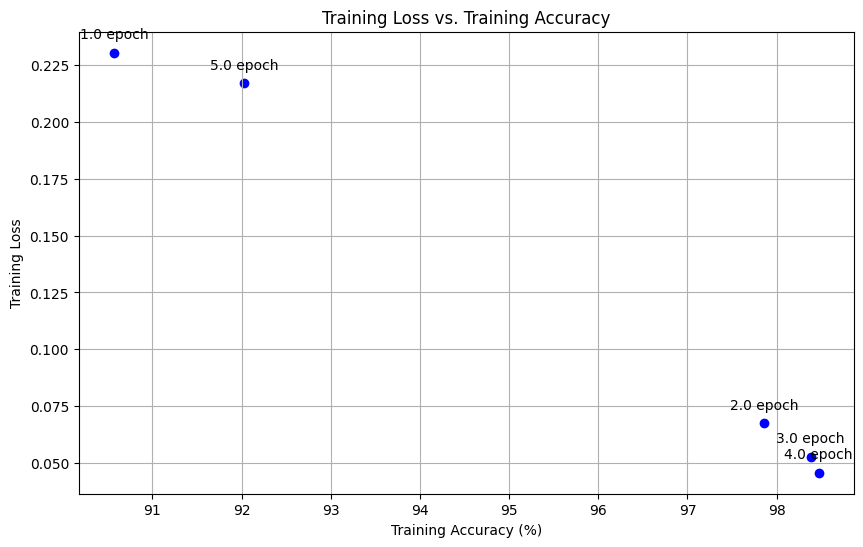

In [ ]:
# Plotting Training Loss vs Training Accuracy without a line linking them
plt.figure(figsize=(10, 6))
plt.scatter(df['Training Accuracy'], df['Training Loss'], color='b')
plt.title('Training Loss vs. Training Accuracy')
plt.xlabel('Training Accuracy (%)')
plt.ylabel('Training Loss')
plt.grid(True)

# Annotating each point with its epoch number
for i, row in df.iterrows():
    plt.annotate(f"{row['Epoch']} epoch", (row['Training Accuracy'], row['Training Loss']),
                 textcoords="offset points", xytext=(0,10), ha='center')

plt.show()
